# Original Code

In [ ]:
# -*- coding: utf-8 -*-
"""
Simulation of a gene regulatory network (SNAIL-ZEB-miR200-miR34 circuit)
using 4th-order Runge-Kutta integration and bifurcation analysis.

Ready to run in Google Colab.
"""

import math
from pathlib import Path
import numpy as np

# -----------------------------
# Simulation parameters
# -----------------------------
NUM_POINTS = 100        # Number of points for bifurcation analysis
STATE_SIZE = 7          # Number of molecules in the system
DT = 0.1                # Time step for RK4 integration
T_END = 1000.0          # Total simulation time for each run

# -----------------------------
# Molecular parameters
# -----------------------------
# Translation efficiencies for ZEB and SNAIL targets
L = np.array([1.0, 0.6, 0.3, 0.1, 0.05, 0.05, 0.05], dtype=np.float64)

# Degradation rates of mRNAs (GAMMA_MRNA) and miRNAs (GAMMA_MIRNA)
GAMMA_MRNA = np.array([0.0, 0.04, 0.2, 1.0, 1.0, 1.0, 1.0], dtype=np.float64)
GAMMA_MIRNA = np.array([0.0, 0.005, 0.05, 0.5, 0.5, 0.5, 0.5], dtype=np.float64)

# Binomial coefficients for multi-site binding
COMB_6 = np.array([math.comb(6, i) for i in range(7)], dtype=np.float64)
COMB_2 = np.array([math.comb(2, i) for i in range(3)], dtype=np.float64)

# Index arrays used in summations
INDICES_7 = np.arange(7, dtype=np.float64)
INDICES_3 = np.arange(3, dtype=np.float64)

# -----------------------------
# Maximum production rates
# -----------------------------
G_MIR34 = 1.35e3
G_MSNAIL = 90.0
G_SNAIL = 0.1e3
G_MIR200 = 2.1e3
G_MZEB = 11.0
G_ZEB = 0.1e3

# -----------------------------
# Decay rate constants
# -----------------------------
K_MIR34 = 0.05
K_MSNAIL = 0.5
K_SNAIL = 0.125
K_MIR200 = 0.05
K_MZEB = 0.5
K_ZEB = 0.1

# -----------------------------
# Hill function thresholds (T), Hill coefficients (N), leak terms (L_)
# -----------------------------
T_MIR34_SNAIL = 300e3
T_MSNAIL_SNAIL = 200e3
T_MIR34_ZEB = 600e3
T_MIR34 = 10e3
T_MSNAIL_I = 50e3
T_MIR200_ZEB = 220e3
T_MIR200_SNAIL = 180e3
T_MZEB_ZEB = 25e3
T_MZEB_SNAIL = 180e3
T_MIR200 = 10e3

N_MIR34_SNAIL = 1
N_MIR34_ZEB = 1
N_MSNAIL_SNAIL = 1
N_MSNAIL_I = 1
N_MIR200_ZEB = 3
N_MIR200_SNAIL = 2
N_MZEB_ZEB = 2
N_MZEB_SNAIL = 2

L_MIR34_SNAIL = 0.1
L_MSNAIL_SNAIL = 0.1
L_MIR34_ZEB = 0.2
L_MSNAIL_I = 10.0
L_MIR200_ZEB = 0.1
L_MIR200_SNAIL = 0.1
L_MZEB_ZEB = 7.5
L_MZEB_SNAIL = 10.0

# -----------------------------
# Hill function for repression
# -----------------------------
def _hill(x: float, threshold: float, hill_n: int, leak: float) -> float:
    """
    Hill repression function with leak.
    Models the effect of molecule x on target repression.

    H(x) = 1 / (1 + (x/T)^n) + leak * (1 - 1 / (1 + (x/T)^n))
    """
    base = 1.0 / (1.0 + (x / threshold) ** hill_n)
    return base + leak * (1.0 - base)

# -----------------------------
# Core gene regulatory network system
# -----------------------------
def snail_zeb_mir200_mir34_system(state: np.ndarray, deriv: np.ndarray) -> None:
    """
    Computes derivatives for the 7-molecule system.

    state = [mir200, mzeb, zeb, snail, msna, mir34, I]
    deriv = d(state)/dt
    """
    # ----- miR-200 dependent terms -----
    fac_mir200_num = state[0] / T_MIR200
    fac_mir200 = np.power(fac_mir200_num, INDICES_7) / np.power(1.0 + fac_mir200_num, 6)
    degrad_mir200 = np.sum(GAMMA_MIRNA * COMB_6 * INDICES_7 * fac_mir200)
    degrad_mzeb = np.sum(GAMMA_MRNA * COMB_6 * fac_mir200)
    trans_mzeb = np.sum(L * COMB_6 * fac_mir200)

    # ----- miR-34 dependent terms -----
    fac_mir34_num = state[5] / T_MIR34
    fac_mir34 = np.power(fac_mir34_num, INDICES_3) / np.power(1.0 + fac_mir34_num, 2)
    degrad_mir34 = np.sum(GAMMA_MIRNA[:3] * COMB_2 * INDICES_3 * fac_mir34)
    degrad_msna = np.sum(GAMMA_MRNA[:3] * COMB_2 * fac_mir34)
    trans_msna = np.sum(L[:3] * COMB_2 * fac_mir34)

    # ----- Hill functions (cross regulations) -----
    h_mir200_zeb = _hill(state[2], T_MIR200_ZEB, N_MIR200_ZEB, L_MIR200_ZEB)
    h_mir200_sna = _hill(state[3], T_MIR200_SNAIL, N_MIR200_SNAIL, L_MIR200_SNAIL)
    h_mzeb_zeb   = _hill(state[2], T_MZEB_ZEB, N_MZEB_ZEB, L_MZEB_ZEB)
    h_mzeb_sna   = _hill(state[3], T_MZEB_SNAIL, N_MZEB_SNAIL, L_MZEB_SNAIL)
    h_mir34_sna  = _hill(state[3], T_MIR34_SNAIL, N_MIR34_SNAIL, L_MIR34_SNAIL)
    h_mir34_zeb  = _hill(state[2], T_MIR34_ZEB, N_MIR34_ZEB, L_MIR34_ZEB)
    h_msna_sna   = _hill(state[3], T_MSNAIL_SNAIL, N_MSNAIL_SNAIL, L_MSNAIL_SNAIL)
    h_msna_i     = _hill(state[6], T_MSNAIL_I, N_MSNAIL_I, L_MSNAIL_I)

    # ----- Differential equations -----
    deriv[0] = G_MIR200 * h_mir200_zeb * h_mir200_sna - state[1] * degrad_mir200 - K_MIR200 * state[0]
    deriv[1] = G_MZEB * h_mzeb_zeb * h_mzeb_sna - state[1] * degrad_mzeb - K_MZEB * state[1]
    deriv[2] = G_ZEB * state[1] * trans_mzeb - K_ZEB * state[2]

    deriv[3] = G_SNAIL * state[4] * trans_msna - K_SNAIL * state[3]
    deriv[4] = G_MSNAIL * h_msna_i * h_msna_sna - state[4] * degrad_msna - K_MSNAIL * state[4]
    deriv[5] = G_MIR34 * h_mir34_zeb * h_mir34_sna - state[4] * degrad_mir34 - K_MIR34 * state[5]
    deriv[6] = 0.0  # Control input (external signal I) is constant

# -----------------------------
# RK4 numerical integrator
# -----------------------------
def rk4_integrate(system, state: np.ndarray, t0: float, t_end: float, dt: float, steady_tol: float | None = None) -> None:
    """
    Runge-Kutta 4th order integrator for ODE systems.
    """
    steps = int((t_end - t0) / dt)
    k1 = np.empty_like(state)
    k2 = np.empty_like(state)
    k3 = np.empty_like(state)
    k4 = np.empty_like(state)
    temp = np.empty_like(state)

    for _ in range(steps):
        system(state, k1)
        temp[:] = state + 0.5 * dt * k1
        system(temp, k2)
        temp[:] = state + 0.5 * dt * k2
        system(temp, k3)
        temp[:] = state + dt * k3
        system(temp, k4)
        delta = (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        state += delta
        # Stop if system has reached steady state
        if steady_tol is not None and np.max(np.abs(delta)) < steady_tol:
            break

# -----------------------------
# Bifurcation analysis function
# -----------------------------
def get_bifurcation(start_val: float, end_val: float, num_points: int = NUM_POINTS) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform bifurcation analysis by varying control input (state[6])
    and computing steady-state SNAIL and mZEB levels.
    """
    control = np.linspace(start_val, end_val, num_points, endpoint=False, dtype=np.float64)
    snail = np.empty(num_points, dtype=np.float64)
    mzeb = np.empty(num_points, dtype=np.float64)
    state = np.zeros(STATE_SIZE, dtype=np.float64)

    for idx, control_value in enumerate(control):
        print(f"Computing point {idx+1}/{num_points}")
        state[6] = control_value
        rk4_integrate(snail_zeb_mir200_mir34_system, state, 0.0, T_END, DT, steady_tol=1e-6)
        mzeb[idx] = state[1]
        snail[idx] = state[3]

    return control, snail, mzeb

# -----------------------------
# Save output to file (optional in Colab)
# -----------------------------
def write_output(path: Path, snail: np.ndarray, mzeb: np.ndarray) -> None:
    data = np.column_stack((snail, mzeb))
    np.savetxt(path, data, fmt="%.10g")

# -----------------------------
# Default run with multiple segments
# -----------------------------
def run_default() -> None:
    """
    Run multiple bifurcation segments and save output.
    """
    segments = [
        get_bifurcation(20e3, 120e3),
        get_bifurcation(120e3, 20e3),
        get_bifurcation(65e3, 20e3),
    ]

    # Save output to a text file in Colab-friendly location
    output_path = Path("core_circuit_output.txt")
    with output_path.open("w", encoding="utf-8") as handle:
        for _, snail, mzeb in segments:
            for s_val, m_val in zip(snail, mzeb):
                handle.write(f"{s_val:.10g} {m_val:.10g}\n")

    print(f"Simulation completed. Output saved to {output_path.resolve()}")

# -----------------------------
# Run the simulationx
# -----------------------------
if __name__ == "__main__":
    run_default()


Computing point 1/100
Computing point 2/100
Computing point 3/100
Computing point 4/100
Computing point 5/100
Computing point 6/100
Computing point 7/100
Computing point 8/100
Computing point 9/100
Computing point 10/100
Computing point 11/100
Computing point 12/100
Computing point 13/100
Computing point 14/100
Computing point 15/100
Computing point 16/100
Computing point 17/100
Computing point 18/100
Computing point 19/100
Computing point 20/100
Computing point 21/100
Computing point 22/100
Computing point 23/100
Computing point 24/100
Computing point 25/100
Computing point 26/100
Computing point 27/100
Computing point 28/100
Computing point 29/100
Computing point 30/100
Computing point 31/100
Computing point 32/100
Computing point 33/100
Computing point 34/100
Computing point 35/100
Computing point 36/100
Computing point 37/100
Computing point 38/100
Computing point 39/100
Computing point 40/100
Computing point 41/100
Computing point 42/100
Computing point 43/100
Computing point 44/1

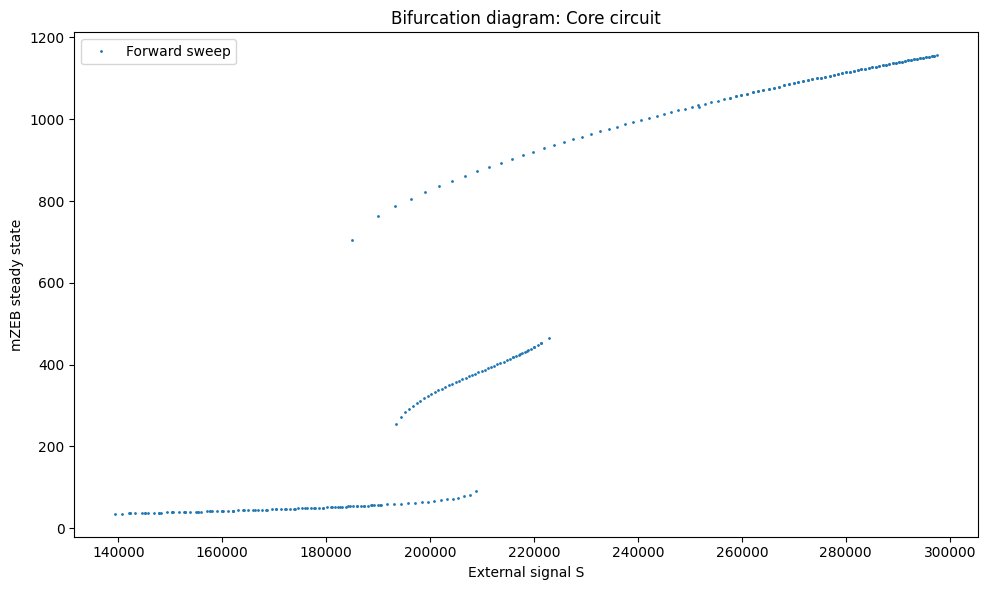

Figure saved to: /content/core_circuit_bifurcation.png


In [ ]:
# -*- coding: utf-8 -*-
"""
Plot bifurcation diagram for the core SNAIL-ZEB-miR200-miR34 circuit
using the simulation output file 'core_circuit_output.txt'.

Ready for Google Colab.
"""

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# -----------------------------
# Load simulation output
# -----------------------------
# Path to the output file from the previous simulation
path = Path("core_circuit_output.txt")

# Load data: first column = S (external signal), second column = mZEB steady state
data = np.loadtxt(path)
S = data[:, 0]      # External signal S
mZEB = data[:, 1]   # Corresponding steady-state mZEB levels

# -----------------------------
# Plot bifurcation diagram
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(S, mZEB, '.', markersize=2, label='Forward sweep')
plt.xlabel('External signal S')
plt.ylabel('mZEB steady state')
plt.title('Bifurcation diagram: Core circuit')
plt.legend()
plt.tight_layout()

# -----------------------------
# Save figure (Colab-friendly)
# -----------------------------
output_fig = Path("core_circuit_bifurcation.png")

# Create directory if it doesn't exist
output_fig.parent.mkdir(parents=True, exist_ok=True)

# Save figure as high-resolution PNG
plt.savefig(output_fig, dpi=300)

# Show the figure inline (especially useful in Colab)
plt.show()

print(f"Figure saved to: {output_fig.resolve()}")


# Faster Code

In [1]:
# -*- coding: utf-8 -*-
"""
Optimized simulation of SNAIL-ZEB-miR200-miR34 gene regulatory network.
Uses Numba for JIT compilation and a custom RK4 integrator for speed.
Includes vectorization and parallel computation for bifurcation analysis.
"""

import math
from pathlib import Path
import numpy as np
from numba import njit, float64
import time

# -----------------------------
# Simulation parameters
# -----------------------------
NUM_POINTS = 100        # Number of points for bifurcation analysis
STATE_SIZE = 7          # Number of molecules in the system
T_END = 1000.0          # Total simulation time for each run
STEADY_TOL = 1e-6       # Steady-state tolerance
DT = 0.1                # Step size for RK4 (similar to max_step)

# -----------------------------
# Molecular parameters
# -----------------------------
L = np.array([1.0, 0.6, 0.3, 0.1, 0.05, 0.05, 0.05], dtype=np.float64)
GAMMA_MRNA = np.array([0.0, 0.04, 0.2, 1.0, 1.0, 1.0, 1.0], dtype=np.float64)
GAMMA_MIRNA = np.array([0.0, 0.005, 0.05, 0.5, 0.5, 0.5, 0.5], dtype=np.float64)

COMB_6 = np.array([math.comb(6, i) for i in range(7)], dtype=np.float64)
COMB_2 = np.array([math.comb(2, i) for i in range(3)], dtype=np.float64)

INDICES_7 = np.arange(7, dtype=np.float64)
INDICES_3 = np.arange(3, dtype=np.float64)

# Maximum production rates
G_MIR34 = 1.35e3
G_MSNAIL = 90.0
G_SNAIL = 0.1e3
G_MIR200 = 2.1e3
G_MZEB = 11.0
G_ZEB = 0.1e3

# Decay constants
K_MIR34 = 0.05
K_MSNAIL = 0.5
K_SNAIL = 0.125
K_MIR200 = 0.05
K_MZEB = 0.5
K_ZEB = 0.1

# Hill thresholds, coefficients, and leak terms
T_MIR34_SNAIL, T_MSNAIL_SNAIL = 300e3, 200e3
T_MIR34_ZEB, T_MIR34, T_MSNAIL_I = 600e3, 10e3, 50e3
T_MIR200_ZEB, T_MIR200_SNAIL, T_MZEB_ZEB, T_MZEB_SNAIL, T_MIR200 = 220e3, 180e3, 25e3, 180e3, 10e3

N_MIR34_SNAIL, N_MIR34_ZEB = 1, 1
N_MSNAIL_SNAIL, N_MSNAIL_I = 1, 1
N_MIR200_ZEB, N_MIR200_SNAIL = 3, 2
N_MZEB_ZEB, N_MZEB_SNAIL = 2, 2

L_MIR34_SNAIL, L_MSNAIL_SNAIL = 0.1, 0.1
L_MIR34_ZEB, L_MSNAIL_I = 0.2, 10.0
L_MIR200_ZEB, L_MIR200_SNAIL = 0.1, 0.1
L_MZEB_ZEB, L_MZEB_SNAIL = 7.5, 10.0

# -----------------------------
# Performance-critical functions
# -----------------------------
@njit(float64(float64, float64, float64, float64), fastmath=True)
def hill(x, threshold, n, leak):
    base = 1.0 / (1.0 + (x / threshold) ** n)
    return base + leak * (1.0 - base)

@njit(float64[:](float64[:]), fastmath=True)
def mir200_terms(state):
    fac_num = state[0] / T_MIR200
    fac = np.power(fac_num, INDICES_7) / np.power(1.0 + fac_num, 6)
    degrad_mir200 = np.sum(GAMMA_MIRNA * COMB_6 * INDICES_7 * fac)
    degrad_mzeb = np.sum(GAMMA_MRNA * COMB_6 * fac)
    trans_mzeb = np.sum(L * COMB_6 * fac)
    return np.array([degrad_mir200, degrad_mzeb, trans_mzeb], dtype=np.float64)

@njit(float64[:](float64[:]), fastmath=True)
def mir34_terms(state):
    fac_num = state[5] / T_MIR34
    fac = np.power(fac_num, INDICES_3) / np.power(1.0 + fac_num, 2)
    degrad_mir34 = np.sum(GAMMA_MIRNA[:3] * COMB_2 * INDICES_3 * fac)
    degrad_msna = np.sum(GAMMA_MRNA[:3] * COMB_2 * fac)
    trans_msna = np.sum(L[:3] * COMB_2 * fac)
    return np.array([degrad_mir34, degrad_msna, trans_msna], dtype=np.float64)

@njit(fastmath=True)
def system_rhs(t, state):
    deriv = np.zeros(STATE_SIZE, dtype=np.float64)
    mir200 = mir200_terms(state)
    mir34 = mir34_terms(state)

    h_mir200_zeb = hill(state[2], T_MIR200_ZEB, N_MIR200_ZEB, L_MIR200_ZEB)
    h_mir200_sna = hill(state[3], T_MIR200_SNAIL, N_MIR200_SNAIL, L_MIR200_SNAIL)
    h_mzeb_zeb = hill(state[2], T_MZEB_ZEB, N_MZEB_ZEB, L_MZEB_ZEB)
    h_mzeb_sna = hill(state[3], T_MZEB_SNAIL, N_MZEB_SNAIL, L_MZEB_SNAIL)
    h_mir34_sna = hill(state[3], T_MIR34_SNAIL, N_MIR34_SNAIL, L_MIR34_SNAIL)
    h_mir34_zeb = hill(state[2], T_MIR34_ZEB, N_MIR34_ZEB, L_MIR34_ZEB)
    h_msna_sna = hill(state[3], T_MSNAIL_SNAIL, N_MSNAIL_SNAIL, L_MSNAIL_SNAIL)
    h_msna_i = hill(state[6], T_MSNAIL_I, N_MSNAIL_I, L_MSNAIL_I)

    deriv[0] = G_MIR200 * h_mir200_zeb * h_mir200_sna - state[1] * mir200[0] - K_MIR200 * state[0]
    deriv[1] = G_MZEB * h_mzeb_zeb * h_mzeb_sna - state[1] * mir200[1] - K_MZEB * state[1]
    deriv[2] = G_ZEB * state[1] * mir200[2] - K_ZEB * state[2]

    deriv[3] = G_SNAIL * state[4] * mir34[2] - K_SNAIL * state[3]
    deriv[4] = G_MSNAIL * h_msna_i * h_msna_sna - state[4] * mir34[1] - K_MSNAIL * state[4]
    deriv[5] = G_MIR34 * h_mir34_zeb * h_mir34_sna - state[4] * mir34[0] - K_MIR34 * state[5]
    deriv[6] = 0.0
    return deriv

# -----------------------------
# Custom Numba RK4 Integrator
# -----------------------------
@njit(fastmath=True)
def rk4_integrate_numba(rhs, y0, t0, t_end, dt):
    steps = int((t_end - t0) / dt)
    y = y0.copy()
    for _ in range(steps):
        k1 = rhs(t0, y)
        k2 = rhs(t0 + 0.5 * dt, y + 0.5 * dt * k1)
        k3 = rhs(t0 + 0.5 * dt, y + 0.5 * dt * k2)
        k4 = rhs(t0 + dt, y + dt * k3)
        y += (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t0 += dt
    return y

# -----------------------------
# Bifurcation analysis
# -----------------------------
def get_bifurcation(start_val: float, end_val: float, num_points: int = NUM_POINTS):
    control = np.linspace(start_val, end_val, num_points, endpoint=False, dtype=np.float64)
    snail = np.empty(num_points, dtype=np.float64)
    mzeb = np.empty(num_points, dtype=np.float64)

    for idx, cv in enumerate(control):
        state0 = np.zeros(STATE_SIZE, dtype=np.float64)
        state0[6] = cv
        final_state = rk4_integrate_numba(system_rhs, state0, 0.0, T_END, DT)
        snail[idx], mzeb[idx] = final_state[3], final_state[1]

    return control, snail, mzeb

# -----------------------------
# Save output
# -----------------------------
def write_output(path: Path, snail: np.ndarray, mzeb: np.ndarray):
    data = np.column_stack((snail, mzeb))
    np.savetxt(path, data, fmt="%.10g")

# -----------------------------
# Default run
# -----------------------------
def run_default():
    start_time = time.time()
    segments = [
        get_bifurcation(20e3, 120e3),
        get_bifurcation(120e3, 20e3),
        get_bifurcation(65e3, 20e3),
    ]

    output_path = Path("core_circuit_output_numba_rk4.txt")
    with output_path.open("w", encoding="utf-8") as handle:
        for _, snail, mzeb in segments:
            for s_val, m_val in zip(snail, mzeb):
                handle.write(f"{s_val:.10g} {m_val:.10g}\n")

    print(f"Simulation completed in {time.time() - start_time:.2f}s")
    print(f"Output saved to {output_path.resolve()}")

# -----------------------------
# Run simulation
# -----------------------------
if __name__ == "__main__":
    run_default()


Simulation completed in 15.96s
Output saved to /content/core_circuit_output_numba_rk4.txt


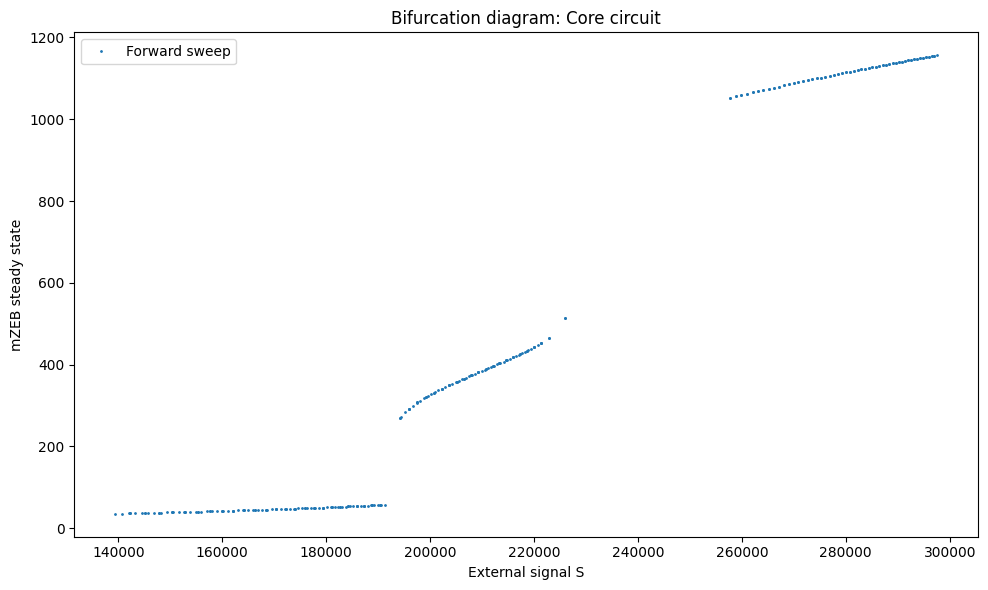

Figure saved to: /content/core_circuit_bifurcation.png


In [2]:
# -*- coding: utf-8 -*-
"""
Plot bifurcation diagram for the core SNAIL-ZEB-miR200-miR34 circuit
using the simulation output file 'core_circuit_output.txt'.

Ready for Google Colab.
"""

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# -----------------------------
# Load simulation output
# -----------------------------
# Path to the output file from the previous simulation
path = Path("core_circuit_output_numba_rk4.txt")

# Load data: first column = S (external signal), second column = mZEB steady state
data = np.loadtxt(path)
S = data[:, 0]      # External signal S
mZEB = data[:, 1]   # Corresponding steady-state mZEB levels

# -----------------------------
# Plot bifurcation diagram
# -----------------------------
plt.figure(figsize=(10, 6))
plt.plot(S, mZEB, '.', markersize=2, label='Forward sweep')
plt.xlabel('External signal S')
plt.ylabel('mZEB steady state')
plt.title('Bifurcation diagram: Core circuit')
plt.legend()
plt.tight_layout()

# -----------------------------
# Save figure (Colab-friendly)
# -----------------------------
output_fig = Path("core_circuit_bifurcation.png")

# Create directory if it doesn't exist
output_fig.parent.mkdir(parents=True, exist_ok=True)

# Save figure as high-resolution PNG
plt.savefig(output_fig, dpi=300)

# Show the figure inline (especially useful in Colab)
plt.show()

print(f"Figure saved to: {output_fig.resolve()}")


# Code With Diffusion

In [ ]:
# -*- coding: utf-8 -*-
"""
Interactive 2D multicellular simulation of SNAIL-ZEB-miR200-miR34 gene regulatory network
with intercellular diffusion and video-like visualization using ipywidgets.
Neumann boundary conditions are applied.
"""

import numpy as np
from numba import njit, prange
import time
import math
from typing import Tuple

# -----------------------------
# Grid and simulation parameters
# -----------------------------
GRID_SIZE = 50             # 10x10 multicellular system
STATE_SIZE = 7             # 7 molecules per cell
T_END = 250.0              # Total simulation time
DT = 0.1                   # Time step
STEPS = int(T_END / DT)    # Number of simulation steps
D_COEFF = np.array([0.5, 0.8, 0.6, 0.4, 0.4, 0.5, 0.0], dtype=np.float64)  # diffusion per molecule
SAVE_EVERY = 1             # save every nth frame for visualization

# -----------------------------
# Molecular parameters
# -----------------------------
L = np.array([1.0, 0.6, 0.3, 0.1, 0.05, 0.05, 0.05], dtype=np.float64)
GAMMA_MRNA = np.array([0.0, 0.04, 0.2, 1.0, 1.0, 1.0, 1.0], dtype=np.float64)
GAMMA_MIRNA = np.array([0.0, 0.005, 0.05, 0.5, 0.5, 0.5, 0.5], dtype=np.float64)
COMB_6 = np.array([math.comb(6, i) for i in range(7)], dtype=np.float64)
COMB_2 = np.array([math.comb(2, i) for i in range(3)], dtype=np.float64)
INDICES_7 = np.arange(7, dtype=np.float64)
INDICES_3 = np.arange(3, dtype=np.float64)

G_MIR34 = 0.1
G_MSNAIL = 0.09
G_SNAIL = 0.1
G_MIR200 = 0.2
G_MZEB = 0.1
G_ZEB = 0.1

K_MIR34 = 0.05
K_MSNAIL = 0.5
K_SNAIL = 0.125
K_MIR200 = 0.05
K_MZEB = 0.5
K_ZEB = 0.1

T_MIR34_SNAIL, T_MSNAIL_SNAIL = 3, 2
T_MIR34_ZEB, T_MIR34 = 4, 5
T_MSNAIL_I, T_MIR200_ZEB = 5, 5
T_MIR200_SNAIL, T_MZEB_ZEB = 4, 3
T_MZEB_SNAIL, T_MIR200 = 4, 5

N_MIR34_SNAIL, N_MIR34_ZEB = 1, 1
N_MSNAIL_SNAIL, N_MSNAIL_I = 1, 1
N_MIR200_ZEB, N_MIR200_SNAIL = 3, 2
N_MZEB_ZEB, N_MZEB_SNAIL = 2, 2

L_MIR34_SNAIL, L_MSNAIL_SNAIL = 0.1, 0.1
L_MIR34_ZEB, L_MSNAIL_I = 0.2, 10.0
L_MIR200_ZEB, L_MIR200_SNAIL = 0.1, 0.1
L_MZEB_ZEB, L_MZEB_SNAIL = 7.5, 10.0

# -----------------------------
# Numba-optimized single-cell dynamics
# -----------------------------
@njit(fastmath=True)
def hill(x: float, threshold: float, n: float, leak: float) -> float:
    base = 1.0 / (1.0 + (x / threshold) ** n)
    return base + leak * (1.0 - base)

@njit(fastmath=True)
def mir200_terms(state: np.ndarray) -> Tuple[float, float, float]:
    fac_num = state[0] / T_MIR200
    fac = np.power(fac_num, INDICES_7) / np.power(1.0 + fac_num, 6)
    degrad_mir200 = np.sum(GAMMA_MIRNA * COMB_6 * INDICES_7 * fac)
    degrad_mzeb = np.sum(GAMMA_MRNA * COMB_6 * fac)
    trans_mzeb = np.sum(L * COMB_6 * fac)
    return degrad_mir200, degrad_mzeb, trans_mzeb

@njit(fastmath=True)
def mir34_terms(state: np.ndarray) -> Tuple[float, float, float]:
    fac_num = state[5] / T_MIR34
    fac = np.power(fac_num, INDICES_3) / np.power(1.0 + fac_num, 2)
    degrad_mir34 = np.sum(GAMMA_MIRNA[:3] * COMB_2 * INDICES_3 * fac)
    degrad_msna = np.sum(GAMMA_MRNA[:3] * COMB_2 * fac)
    trans_msna = np.sum(L[:3] * COMB_2 * fac)
    return degrad_mir34, degrad_msna, trans_msna

@njit(fastmath=True)
def cell_rhs(state: np.ndarray) -> np.ndarray:
    deriv = np.zeros(STATE_SIZE, dtype=np.float64)
    mir200 = mir200_terms(state)
    mir34 = mir34_terms(state)

    h_mir200_zeb = hill(state[2], T_MIR200_ZEB, N_MIR200_ZEB, L_MIR200_ZEB)
    h_mir200_sna = hill(state[3], T_MIR200_SNAIL, N_MIR200_SNAIL, L_MIR200_SNAIL)
    h_mzeb_zeb = hill(state[2], T_MZEB_ZEB, N_MZEB_ZEB, L_MZEB_ZEB)
    h_mzeb_sna = hill(state[3], T_MZEB_SNAIL, N_MZEB_SNAIL, L_MZEB_SNAIL)
    h_mir34_sna = hill(state[3], T_MIR34_SNAIL, N_MIR34_SNAIL, L_MIR34_SNAIL)
    h_mir34_zeb = hill(state[2], T_MIR34_ZEB, N_MIR34_ZEB, L_MIR34_ZEB)
    h_msna_sna = hill(state[3], T_MSNAIL_SNAIL, N_MSNAIL_SNAIL, L_MSNAIL_SNAIL)
    h_msna_i = hill(state[6], T_MSNAIL_I, N_MSNAIL_I, L_MSNAIL_I)

    deriv[0] = G_MIR200 * h_mir200_zeb * h_mir200_sna - state[1] * mir200[0] - K_MIR200 * state[0]
    deriv[1] = G_MZEB * h_mzeb_zeb * h_mzeb_sna - state[1] * mir200[1] - K_MZEB * state[1]
    deriv[2] = G_ZEB * state[1] * mir200[2] - K_ZEB * state[2]

    deriv[3] = G_SNAIL * state[4] * mir34[2] - K_SNAIL * state[3]
    deriv[4] = G_MSNAIL * h_msna_i * h_msna_sna - state[4] * mir34[1] - K_MSNAIL * state[4]
    deriv[5] = G_MIR34 * h_mir34_zeb * h_mir34_sna - state[4] * mir34[0] - K_MIR34 * state[5]
    deriv[6] = 0.0
    return deriv

# -----------------------------
# Optimized 2D Laplacian
# -----------------------------
@njit(parallel=True, fastmath=True)
def laplacian_2d_optimized(grid: np.ndarray, lap: np.ndarray) -> np.ndarray:
    nx, ny, ns = grid.shape
    for i in prange(1, nx-1):
        for j in range(1, ny-1):
            for k in range(ns):
                lap[i,j,k] = (
                    grid[i+1,j,k] + grid[i-1,j,k] +
                    grid[i,j+1,k] + grid[i,j-1,k] -
                    4.0*grid[i,j,k]
                )

    for k in prange(ns):
        # Left and right boundaries
        for j in range(ny):
            lap[0,j,k] = (
                2.0*grid[1,j,k] +
                grid[0,j-1 if j>0 else j,k] +
                grid[0,j+1 if j<ny-1 else j,k] -
                4.0*grid[0,j,k]
            )
            lap[nx-1,j,k] = (
                2.0*grid[nx-2,j,k] +
                grid[nx-1,j-1 if j>0 else j,k] +
                grid[nx-1,j+1 if j<ny-1 else j,k] -
                4.0*grid[nx-1,j,k]
            )
        # Top and bottom boundaries
        for i in range(1, nx-1):
            lap[i,0,k] = (
                grid[i-1,0,k] + grid[i+1,0,k] +
                2.0*grid[i,1,k] -
                4.0*grid[i,0,k]
            )
            lap[i,ny-1,k] = (
                grid[i-1,ny-1,k] + grid[i+1,ny-1,k] +
                2.0*grid[i,ny-2,k] -
                4.0*grid[i,ny-1,k]
            )

    return lap

# -----------------------------
# Optimized simulation with frame saving
# -----------------------------
@njit(fastmath=True)
def simulate_multicell_frames(grid: np.ndarray, dt: float, steps: int, D: np.ndarray, save_every: int) -> np.ndarray:
    nx, ny, ns = grid.shape
    tmp = np.zeros_like(grid)
    lap = np.zeros_like(grid)
    n_frames = steps // save_every + 1
    frames = np.zeros((n_frames, nx, ny, ns), dtype=np.float64)

    frame_idx = 0
    frames[frame_idx] = grid.copy()
    frame_idx += 1

    for t in range(1, steps+1):
        laplacian_2d_optimized(grid, lap)
        for i in range(nx):
            for j in range(ny):
                rhs = cell_rhs(grid[i,j,:])
                for k in range(ns):
                    tmp[i,j,k] = grid[i,j,k] + dt*(rhs[k] + D_COEFF[k]*lap[i,j,k])
        grid[:,:,:] = tmp[:,:,:]
        if t % save_every == 0:
            frames[frame_idx] = grid.copy()
            frame_idx += 1
    return frames

# -----------------------------
# Initialize and run simulation
# -----------------------------
if __name__ == "__main__":

  np.random.seed(42)

  GRID_SIZE = 50      # example grid size
  STATE_SIZE = 7      # number of molecules per cell

  # Initialize the full grid with very low concentrations
  grid_init = np.zeros((GRID_SIZE, GRID_SIZE, STATE_SIZE))

  # Define central square coordinates
  center = GRID_SIZE // 2
  half_patch = 6  # 5x5 square -> 2 cells around the center

  # High concentration values for the central patch
  high_conc_min = 50
  high_conc_max = 60

  # Low concentration values for the rest of the grid
  low_conc_min = 1
  low_conc_max = 5

  for k in range(STATE_SIZE):
      # Fill entire grid with low concentrations + tiny noise
      grid_init[:, :, k] = np.random.uniform(low_conc_min, low_conc_max, (GRID_SIZE, GRID_SIZE))

      # Overwrite central 5x5 square with high concentrations
      grid_init[center-half_patch:center+half_patch+1,
                center-half_patch:center+half_patch+1,
                k] = np.random.uniform(high_conc_min, high_conc_max, (13, 13))

  # Optional: tiny random noise to break symmetry
  grid_init += np.random.rand(GRID_SIZE, GRID_SIZE, STATE_SIZE) * 0.5


  start_time = time.time()
  frames = simulate_multicell_frames(grid_init, DT, STEPS, D_COEFF, SAVE_EVERY)
  print(f"Simulation done in {time.time()-start_time:.2f}s")
  n_frames = frames.shape[0]

  # -----------------------------
  # Interactive visualization
  # -----------------------------
  from ipywidgets import Play, IntSlider, jslink, HBox, ToggleButtons, interact
  from IPython.display import display
  import matplotlib.pyplot as plt
  from google.colab import output
  output.enable_custom_widget_manager()

  # Let's define species mapping
  species_map = {
      "ZEB": 2,
      "SNAIL": 3,
      "MIR200": 0,
      "MIR34": 5
    }

  # Function to plot a given species at a given frame
  def plot_at_time(idx: int, species: str) -> None:
      plt.figure(figsize=(6,6))
      k = species_map[species]
      data = frames[idx, :, :, k]
      title = f"{species} Concentration (t={idx * SAVE_EVERY * DT:.2f})"
      img = plt.imshow(data, cmap='viridis', interpolation='bilinear')
      plt.colorbar(img, ax=plt.gca(), label=f"{species} concentration")
      plt.title(title)
      plt.axis('off')
      plt.show()

  # Species toggle
  species_toggle = ToggleButtons(
      options=list(species_map.keys()),
      value="ZEB",
      description="Species:",
      button_style="info"
    )

  # Frame controls
  play = Play(value=0, min=0, max=frames.shape[0]-1, step=1, interval=100, description="Play")
  slider = IntSlider(value=0, min=0, max=frames.shape[0]-1, step=1, description='Frame')

  # Layout with toggle button
  widgets = HBox([play, slider, species_toggle])
  interact_ui = interact(plot_at_time, idx=slider, species=species_toggle)

  # Link play and slider
  jslink((play, 'value'), (slider, 'value'))

  # Display everything
  display(widgets, interact_ui)


Simulation done in 22.40s


interactive(children=(IntSlider(value=0, description='Frame', max=2500), ToggleButtons(button_style='info', de…

<function __main__.plot_at_time(idx: int, species: str) -> None>